# Generating graphs from results

In [26]:
import pandas as pd
import baseline.config as cfg
import matplotlib.pyplot as plt
import numpy as np
import os
import csv

In [110]:
def generate_graphs(metrics_filepath, epoch_filepath): 
    dirpath = os.path.splitext(metrics_filepath)[0]
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)
        
    df = pd.read_csv(metrics_filepath, sep=";")
    del df["Acc_Seg"]
    df.columns = ['weak-F1', 'Nref', "F", "Pre", "Rec", "Acc", "Nref_Seg", "F_seg", "Pre_Seg", "Rec_Seg", "Acc_Seg"]
    for column in df.columns:
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.set(xlabel="Epoch", ylabel=column)
        pl = df.groupby(df.index)[column].plot(legend=True,
                                          ax=ax,
                                          use_index=False,
                                          title="{} values for each epoch".format(column))
        plt.savefig(os.path.join(dirpath, column))
        plt.close()
        
    dirpath = os.path.splitext(epoch_filepath)[0]
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)    
    df2 = pd.read_csv(epoch_filepath, sep=";", skiprows=2)
    for column in df2.columns:
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.set(xlabel="Epoch", ylabel=column)
        pl = df2.plot(y=column, 
                 use_index=True, 
                 ax=ax, 
                 title="{} values for each epoch".format(column),
                 legend=False)
        plt.savefig(os.path.join(dirpath, column))

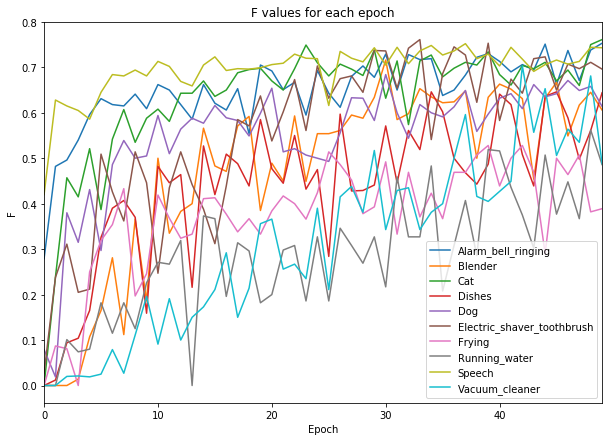

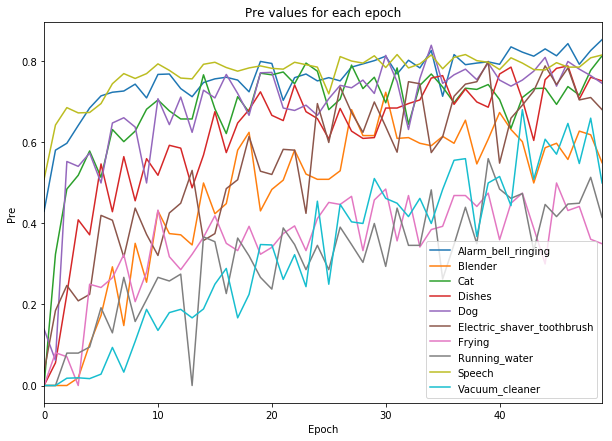

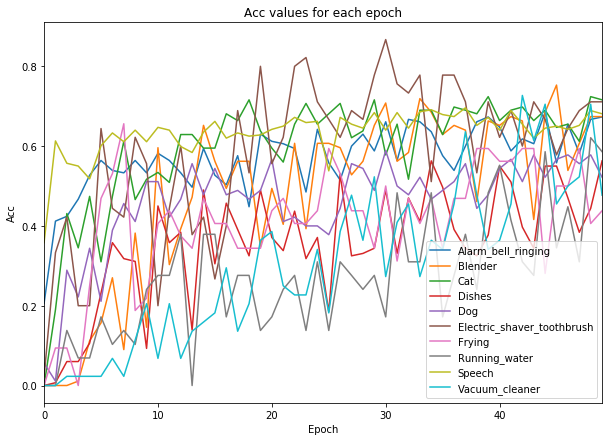

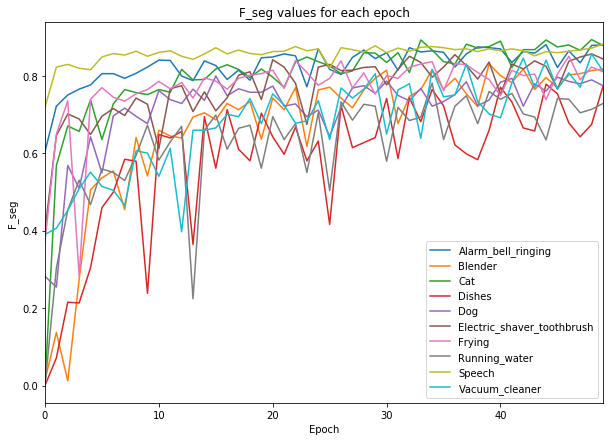

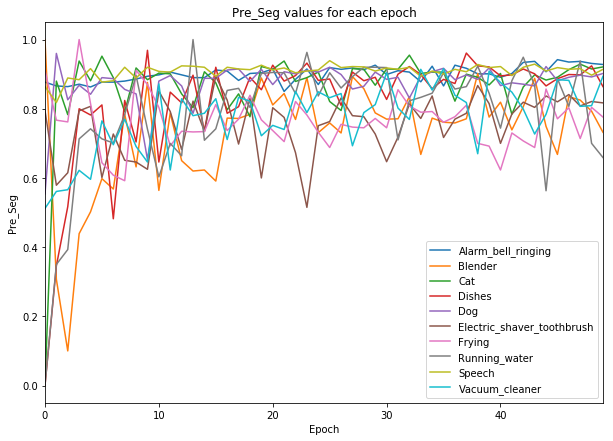

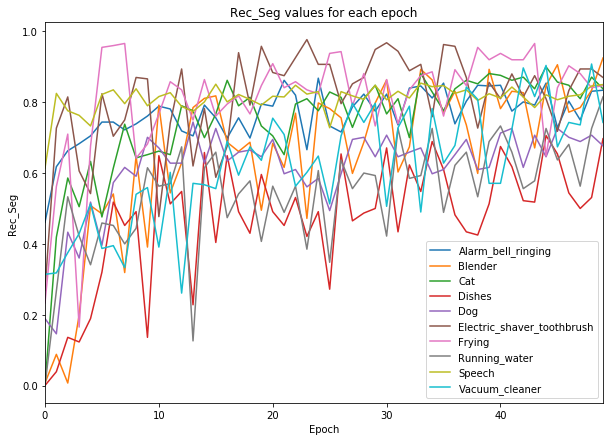

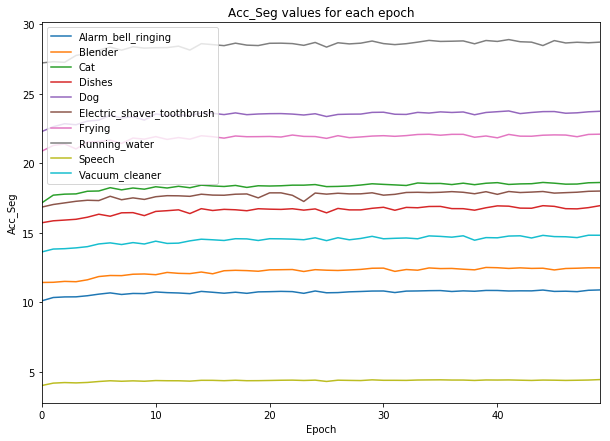

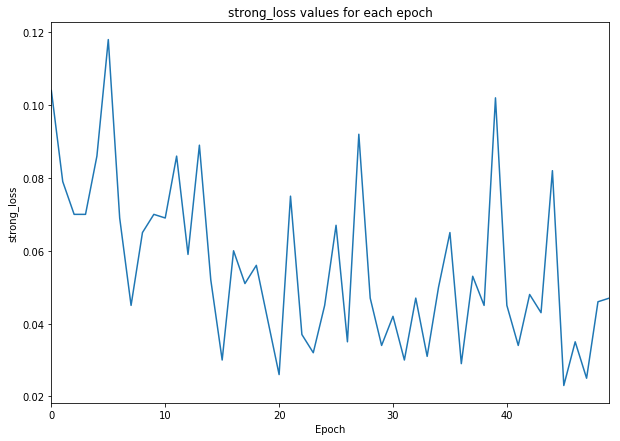

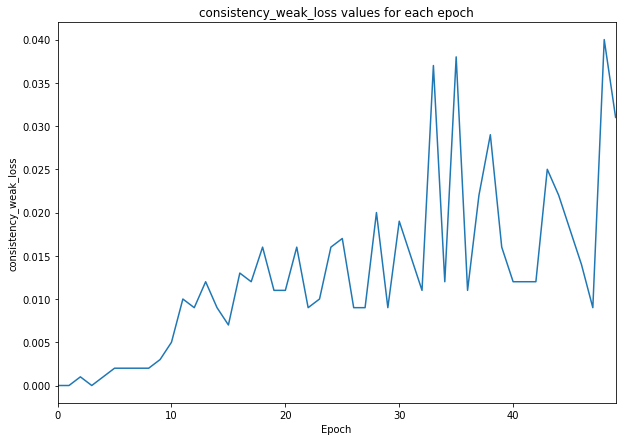

In [14]:
# metrics_filepath = "results\class_11-01-2020_18-37-34.csv"
# epoch_filepath = os.path.join("results", "11-01-2020_18-37-34.csv")
# metrics_filepath = "results\class_11-01-2020_21-19-49.csv"
# epoch_filepath = os.path.join("results", "11-01-2020_21-19-49.csv")
metrics_filepath = "results\class_11-01-2020_22-55-30.csv"
epoch_filepath = os.path.join("results", "11-01-2020_22-55-30.csv")

generate_graphs(metrics_filepath, epoch_filepath)

In [303]:
def find_names(df, lst):
    new_names = np.zeros_like(lst)
    
    for ind, name in enumerate(lst):
        index = df.index[df["filename"]==name].tolist()
        if index:
            snr = " SNR " if df.at[index[0], "use_snr"]=="True" else ""
            sort = " SORT " if df.at[index[0], "sort"]=="True" else ""
            sf = " SF " if df.at[index[0], "use_flatness"]=="True" else ""
            new_names[ind] = name + snr + sort + sf
    return new_names
    

In [304]:
def plot_summary(df, df_info, initialized):
    df.columns = find_names(df_info, df.columns)
    init = "initialized" if initialized else "not initialized"
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set(xlabel="Epoch", ylabel=df.name)
    df.plot(ax=ax,
            use_index=True, 
            legend=True,
            title="{} for models {} with weights".format(df.name, init))
    plotdir = os.path.join(directory, "overall")
    if not os.path.exists(plotdir):
        os.mkdir(plotdir)
    plt.savefig(os.path.join(plotdir, df.name+ " " + init))
    plt.close()

In [306]:
directory = "results"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join("results", f))]

class_files = [file for file in files if "class" in file]
summary_files = [file for file in files if file not in class_files]
# for f in summary_files:
#     metrics_filepath = os.path.join("results", "class_" + f)
#     epoch_filepath = os.path.join("results", f)
#     generate_graphs(metrics_filepath, epoch_filepath)

columnNames = ["filename", "freeze_cnn", "freeze_rnn", "model_path", "no_download", "skip_cnn", "skip_dense", "skip_rnn", "skip_unlabeled", "sort", "subpart_data", "use_flatness", "use_snr"]
df = pd.DataFrame(columns=columnNames, index=np.arange(len(summary_files)))
df_weakF1_init = pd.DataFrame(columns=summary_files, index = np.arange(50))
df_weakF1_notinit = pd.DataFrame(columns=summary_files, index = np.arange(50))
df_F_init = pd.DataFrame(columns=summary_files, index = np.arange(50))
df_F_notinit = pd.DataFrame(columns=summary_files, index = np.arange(50))
df_Fseg_init = pd.DataFrame(columns=summary_files, index = np.arange(50))
df_Fseg_notinit = pd.DataFrame(columns=summary_files, index = np.arange(50))
df_loss_init = pd.DataFrame(columns=summary_files, index = np.arange(50))
df_loss_notinit = pd.DataFrame(columns=summary_files, index = np.arange(50))
df_weakF1_init.name = "Weak F1 score"
df_weakF1_notinit.name = "Weak F1 score"
df_F_init.name = "Event-based F1 score"
df_F_notinit.name = "Event-based F1 score"
df_Fseg_init.name = "Segment-based F1 score"
df_Fseg_notinit.name = "Segment-based F1 score"
df_loss_init.name = "Loss function"
df_loss_notinit.name = "Loss function"

i = 0
for filename in summary_files:
    row = []
    row

    with open(os.path.join(directory, filename), newline='') as f:
        reader = csv.reader(f)
        row = next(reader)
        row[0] = row[0].replace("Namespace(", "")
        df.at[i, "filename"] = filename
        for r in row:
            r = r.replace(" ", "").replace(")","")
            index = r.index("=")
            df.at[i, r[:index]] = r[index+1:]
    df_cl = pd.read_csv(os.path.join(directory,"class_"+filename), sep=";")
    df_sum = pd.read_csv(os.path.join(directory, filename), sep=";", skiprows=2)
    if (df_cl.shape[0]/10 == 50):
        del df_cl["Acc_Seg"]
        df_cl.columns = ['weak-F1', 'Nref', "F", "Pre", "Rec", "Acc", "Nref_Seg", "F_seg", "Pre_Seg", "Rec_Seg", "Acc_Seg"]
        df_cl_epochs = df_cl.groupby(np.arange(len(df_cl))//10).mean()
        
        if df.iloc[i]["model_path"] == "None":
            df_loss_notinit[filename]=df_sum["loss"].values
            df_weakF1_notinit[filename]=df_cl_epochs["weak-F1"].values
            df_F_notinit[filename]=df_cl_epochs["F"].values
            df_Fseg_notinit[filename]=df_cl_epochs["F_seg"].values
            del df_loss_init[filename]
            del df_weakF1_init[filename]
            del df_F_init[filename]
            del df_Fseg_init[filename]
        else:
            df_loss_init[filename]=df_sum["loss"].values
            df_weakF1_init[filename]=df_cl_epochs["weak-F1"].values
            df_F_init[filename]=df_cl_epochs["F"].values
            df_Fseg_init[filename]=df_cl_epochs["F_seg"].values
            del df_loss_notinit[filename]
            del df_weakF1_notinit[filename]
            del df_F_notinit[filename]
            del df_Fseg_notinit[filename]
        i+=1
    else:
        del df_weakF1_init[filename]
        del df_weakF1_notinit[filename]
        del df_F_init[filename]
        del df_F_notinit[filename]
        del df_Fseg_init[filename]
        del df_Fseg_notinit[filename]
        del df_loss_init[filename]
        del df_loss_notinit[filename]

find_names(df, summary_files)
plot_summary(df_loss_init, df, True)
plot_summary(df_loss_notinit, df, False)
plot_summary(df_weakF1_init, df, True)
plot_summary(df_weakF1_notinit, df, False)
plot_summary(df_Fseg_init, df, True)
plot_summary(df_Fseg_notinit, df, False)
plot_summary(df_F_init, df, True)
plot_summary(df_F_notinit, df, False)